# Recommendation algorithms in Python

In this lab, we will implement different recommendation algorithms and evaluate their performance on a movie rating prediction task.

**Task 1:** First, we will build a simple item-based kNN recommendation algorithm with different item feature representations. We will visualize the item vectors on a 2D plot.

**Task 2:** Next, we will use the `surprise` Python package with different collaborative filtering recommendation algorithm implementations and compare their performance for different hyperparametes setting on a standard movie ratings dataset. 

In [6]:
!pip install umap-learn surprise

In [7]:
import urllib.request
import pandas as pd
import numpy as np
import zipfile
import os
import datetime

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
import umap 
import plotly.express as px

## Task 1: Item-based kNN recommendations with different item representations

First, we wil implement an item-based approach to recommendations based on k Nearest Neighbors (kNN) model. 

### Read the data
We use a small version of the popular MovieLens movie recommendation dataset from GroupLens https://grouplens.org/datasets/movielens/

In [8]:
data_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
urllib.request.urlretrieve(data_url, 'movielens.zip')
movies_file = zipfile.ZipFile('movielens.zip')
data_filename = 'ml-latest-small'

ratings = pd.read_csv(movies_file.open('ml-latest-small/ratings.csv'))
movies = pd.read_csv(movies_file.open('ml-latest-small/movies.csv'))

### Exploratory data analysis 
First, we perform an exploratory analysis to learn basic characteristics of the dataset.


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


What is the rating time distribution?

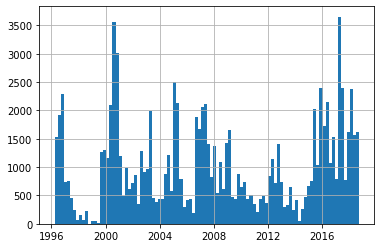

In [10]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['datetime'].hist(bins=100)

What is the rating values distribution?

In [11]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

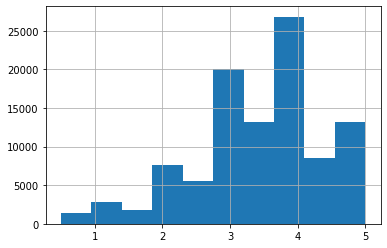

In [12]:
ratings.rating.hist(bins=10)

We can observe that each user has rated relatively few movies - the rating matrix is sparse which is a significant problem for the recommendation systems.

In [13]:
ratings.groupby('movieId').count()['rating'].describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

In [14]:
ratings.groupby('userId').count()['rating'].describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

### Calculate the density of the ratings matrix
  <font color='red'>**ToDo:**</font>
Matrix density is the fraction of non-zero elements in the matrix:  
 
 **density = nr of ratings / (nr of users * nr of items)**

In [21]:
density = ratings.shape[0] / (ratings.userId.nunique() * ratings.movieId.nunique())
density

0.016999683055613623

### Item-based kNN recommendations
We will test a simple item-based kNN recommender. We will define the similarity between movies for different movie representations and return most similar movies to selected one.


In [22]:
def get_similar_movies(movie_id: int, similarity_df: pd.DataFrame, n_neighbors:int=5):
    similar_ids = similarity_df.loc[movie_id].sort_values(ascending=False)[1:n_neighbors+1].reset_index()
    return similar_ids.merge(movies, on='movieId')[['title', 'genres']]


def plot_2d_movies(movie_vectors: pd.DataFrame, movie_metadata: pd.DataFrame, samp_size: int=2000) -> None:
    features_sample = movie_vectors.sample(samp_size)
    features_sample_2d = umap.UMAP().fit(features_sample).transform(features_sample)
    df = pd.DataFrame(features_sample_2d, index=features_sample.index, columns=['x', 'y'])
    df = df.merge(movie_metadata, left_index=True, right_on='movieId')[['x', 'y', 'title', 'genres']]
    fig = px.scatter(df, x='x', y='y', hover_name="title", hover_data=['genres'])
    fig.update_traces(textposition='top center')
    fig.update_layout(height=800)
    fig.show()


We select an example of a movie for a qualitative evaluation of different methods.

In [25]:
test_movie = movies.iloc[0]
test_movie

movieId                                              1
title                                 Toy Story (1995)
genres     Adventure|Animation|Children|Comedy|Fantasy
Name: 0, dtype: object

### Content-Based Recommendations

As the first approach, we use the content-based features of movies to calculate their similarity - in this case these are the movie genres.

In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


 <font color='red'>**ToDo:**</font>
- Use sklearn `CountVectorizer`  to build the content-based the movies features matrix from their genres https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html.
- Split the lists of genres with | separator (use argument `token_pattern='[^|]+'` for `CountVectorizer`)



In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern='[^|]+')
content_features = pd.DataFrame(vectorizer.fit_transform(movies['genres']).toarray(), columns=vectorizer.get_feature_names(), index=movies['movieId'])
content_features.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Plot 2D movie representations

We will use UMAP algorithm for transforming the multi-dimensional vectors into 2D space and Plotly for interactive plot of 2D vectors: https://plotly.com/python/plotly-express/.

You can read more and experiment with UMAP: https://pair-code.github.io/understanding-umap/

<font color='red'>**ToDo:**</font>

Plot  `content_features` vectors in 2D using `plot_2d_movies` function

In [29]:
plot_2d_movies(movie_vectors=content_features, movie_metadata=movies)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



We qill use pairwise cosine similarity between movie feature vectors to calculate the similarity matrix for all movies.

<font color='red'>**ToDo:**</font>
 - Build the similarity matrix for movies based on their `content_features`. 
 
 Hint: use `cosine_similarity` function https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_content_mx = cosine_similarity(content_features)
movie_similarity_content = pd.DataFrame(cosine_similarity_content_mx,
                                        columns=content_features.index, 
                                        index=content_features.index)
movie_similarity_content.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.774597,0.316228,0.258199,0.447214,0.0,0.316228,0.632456,0.0,0.258199,0.258199,0.316228,0.774597,0.00000,0.258199,0.000000,0.000000,0.447214,0.447214,0.200000,0.258199,0.000000,0.0,0.000000,0.000000,0.00000,0.316228,0.000000,0.400000,0.000000,0.00000,0.0,0.316228,0.000000,0.632456,0.316228,0.00000,0.000000,0.000000,0.00000,...,0.0,0.316228,0.447214,0.258199,0.258199,0.200000,0.67082,0.258199,0.447214,0.0,0.516398,0.600000,0.000000,0.316228,0.447214,0.774597,0.316228,0.0,0.258199,0.0,0.0,0.258199,0.0,0.000000,0.447214,0.00000,0.00000,0.447214,0.0,0.447214,0.447214,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
2,0.774597,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,0.000000,0.000000,0.666667,0.00000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.408248,0.000000,0.516398,0.000000,0.00000,0.0,0.408248,0.000000,0.408248,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.333333,0.333333,0.258199,0.57735,0.000000,0.577350,0.0,0.333333,0.516398,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.288675,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
3,0.316228,0.000000,1.000000,0.816497,0.707107,0.0,1.000000,0.000000,0.0,0.000000,0.816497,0.500000,0.000000,0.00000,0.408248,0.000000,0.500000,0.707107,0.707107,0.316228,0.408248,0.000000,0.0,0.000000,0.500000,0.00000,0.000000,0.500000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.500000,1.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.500000,0.707107,0.000000,0.000000,0.000000,0.00000,0.408248,0.000000,0.0,0.408248,0.316228,0.000000,1.000000,0.707107,0.408248,0.500000,0.0,0.000000,0.0,0.0,0.408248,0.0,0.500000,0.707107,0.00000,0.00000,0.000000,0.0,0.353553,0.353553,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
4,0.258199,0.000000,0.816497,1.000000,0.577350,0.0,0.816497,0.000000,0.0,0.000000,1.000000,0.408248,0.000000,0.57735,0.333333,0.408248,0.816497,0.577350,0.577350,0.516398,0.333333,0.258199,0.0,0.408248,0.816497,0.57735,0.408248,0.816497,0.258199,0.408248,0.57735,0.0,0.408248,0.408248,0.408248,0.816497,0.57735,0.408248,0.333333,0.57735,...,0.0,0.408248,0.577350,0.000000,0.000000,0.258199,0.00000,0.333333,0.000000,0.0,0.333333,0.258199,0.408248,0.816497,0.577350,0.333333,0.816497,0.0,0.000000,0.0,0.0,0.666667,0.0,0.816497,0.577350,0.57735,0.57735,0.000000,0.0,0.288675,0.288675,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
5,0.447214,0.000000,0.707107,0.577350,1.000000,0.0,0.707107,0.000000,0.0,0.000000,0.577350,0.707107,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.447214,0.577350,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.707107,0.707107,0.00000,0.000000,0.000000,0.00000,...,0.0,0.707107,1.000000,0.000000,0.000000,0.000000,0.00000,0.577350,0.000000,0.0,0.577350,0.447214,0.000000,0.707107,1.000000,0.577350,0.707107,0.0,0.000000,0.0,0.0,0.577350,0.0,0.000000,1.000000,0.00000,0.00000,0.000000,0.0,0.500000,0.500000,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000


The most similar movies to "Toy Story" based on the content features:

In [34]:
get_similar_movies(test_movie['movieId'], movie_similarity_content)

,title,genres
0,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
1,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
2,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy
3,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
4,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy


### Collaborative Filtering recommendations

The content-based approach is simple and quite effective (even in the new item situation) but it does not consider the information about the interaction patterns. To address this problem, we will implement a collaborative-filtering kNN recommendation algorithm which calculates the movies similarity based on the user rating matrix.


#### Build a user-movie rating matrix
First, we will construct the rating matrix $R$. Note that our rating matrix is sparse (there are many empty values) - we fill them with 0s. In this exercise we use a small dataset but for larger ones it is more efficient to use a sparse matrix instead of the dense one (we use a dense matrix due to better readability).

<font color='red'>**ToDo:**</font>
- Construct a pivot table with user ids as columns, movie ids as index and user-movie ratings as values. 

Hint: 
You may use `df.pivot_table(index=..., columns=..., values=...)` https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

In [41]:
rating_mx = ratings.pivot_table(index='movieId', columns='userId', values='rating')
rating_mx.fillna(0, inplace=True)
rating_mx.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Plot  `rating_mx` vectors in 2D using `plot_2d_movies` function

In [42]:
plot_2d_movies(movie_vectors=rating_mx, movie_metadata=movies)

 <font color='red'>**ToDo:**</font>
 - Build the similarity matrix for movies based on their `rating_mx`. 

In [43]:
cosine_similarity_cf_mx = cosine_similarity(rating_mx)
movie_similarity_cf = pd.DataFrame(cosine_similarity_cf_mx, columns=rating_mx.index, index=rating_mx.index)
movie_similarity_cf.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,0.323976,0.219680,0.151236,0.178144,0.104528,0.292152,0.334693,0.167993,0.383641,0.147039,0.335337,0.226570,0.164626,0.215168,0.324072,0.170520,0.106747,0.124567,0.190233,0.047388,0.178382,0.508593,0.505196,0.289150,0.135167,0.351076,0.041815,0.117506,0.101851,0.101023,...,0.039836,0.068056,0.068056,0.052282,0.068056,0.03607,0.047256,0.095825,0.088476,0.025521,0.025521,0.119572,0.000000,0.0,0.068056,0.000000,0.0,0.0,0.0,0.000000,0.0,0.025521,0.051042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,0.322252,0.168642,0.194398,0.099373,0.229191,0.239683,0.208254,0.182717,0.497560,0.129955,0.273282,0.244361,0.128695,0.203931,0.159834,0.162491,0.151033,0.102551,0.163939,0.018742,0.244840,0.381811,0.453192,0.180312,0.148042,0.359441,0.000000,0.121620,0.044393,0.143692,...,0.134047,0.107667,0.000000,0.060311,0.000000,0.00000,0.000000,0.162151,0.202349,0.000000,0.000000,0.084074,0.094208,0.0,0.000000,0.094208,0.0,0.0,0.0,0.094208,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,0.249568,0.203237,0.144049,0.176544,0.144100,0.294055,0.215245,0.200013,0.279409,0.094867,0.302458,0.251466,0.151596,0.291192,0.214832,0.198667,0.256104,0.096027,0.114349,0.000000,0.207695,0.287436,0.220458,0.290828,0.099034,0.244895,0.099570,0.191409,0.136112,0.200830,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.064119,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,0.153910,0.000000,0.152057,0.110435,0.157336,0.112660,0.236706,0.000000,0.074807,0.000000,0.129864,0.160161,0.000000,0.131412,0.179436,0.178241,0.129602,0.053394,0.040659,0.000000,0.281444,0.086558,0.123893,0.235246,0.000000,0.058324,0.000000,0.125394,0.000000,0.198794,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,0.272182,0.207889,0.116569,0.255333,0.103934,0.194478,0.276254,0.228271,0.281046,0.051730,0.224821,0.216080,0.163674,0.235350,0.289412,0.217173,0.279038,0.037623,0.143247,0.000000,0.252241,0.285743,0.263195,0.301824,0.104168,0.246391,0.000000,0.178707,0.021816,0.283314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.035327,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
get_similar_movies(test_movie['movieId'], movie_similarity_cf)

,title,genres
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
1,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
2,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
3,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,Forrest Gump (1994),Comedy|Drama|Romance|War


## Task 2: Comparing the performance of different recommendation algorithms 
In this task, we will use `surprise` python package to evaluate the performance of different collaborative filtering recommendation algorithms on the movie recommendation task for a larger dataset.

We will use the build-in MovieLens 100K dataset.

https://surprise.readthedocs.io/en/stable/


In [45]:
from surprise import NMF, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, NormalPredictor
from surprise import Dataset
from surprise.model_selection import GridSearchCV

def evaluate_models(models: list, param_grid: dict, test_metrics: list) -> pd.DataFrame:
    results = pd.DataFrame()
    for model in models:
        print('Evaluating model: {}'.format(model.__name__))
        search = GridSearchCV(model, param_grid, measures=test_metrics, cv=cv, n_jobs=-1)
        search.fit(data)
        model_cv_results = pd.DataFrame(search.cv_results)
        model_cv_results['model'] = model.__name__
        model_cv_results['params'] = model_cv_results['params'].astype(str)
        results = results.append(model_cv_results, sort=False)
    return results


# use the 100K movie recommendation dataset.
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


### Model selection 

We will compare several types of models and search for best configurations.

For each group of models prepare a list of classes and parameters for the grid search:

`some_models = [SomeModel1, SomeModel2]
 param_grid = {'param1': [1,2,3],
               'param2': [True, False]}`
               

<font color='red'>**ToDo:**</font>
Prepare the configuration for three types of models:
* Baseline model: use `NormalPredictor` model which predicts a random rating based on the distribution of the training set. This baseline does not require any parameters (grid will be empty).
Docs: https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor

* KNN models: use  `KNNBasic`,  `KNNWithZScore`.
Prepare the hyperparameters grid for the neighborhood-based models - `k` - number of neighbors (20 and 50) and boolean `user_based` (`True` and `False` for using user or item-based similarity).
Docs: https://surprise.readthedocs.io/en/stable/knn_inspired.html

* Matrix Factorization models: use `SVD`, `NMF`. Prepare the hyperparameters grid for the MF models - `n_factors` - number of latent dimensions (20 and 50). Docs: https://surprise.readthedocs.io/en/stable/matrix_factorization.html



In [53]:
baseline_models = [NormalPredictor]
param_grid_baseline = {}


knn_models = [KNNBasic, KNNWithZScore]
param_grid_neighbors = {'k': [20, 50], 'user_based': [True, False]}


mf_models = [SVD, NMF]
param_grid_mf = {'n_factors': [20, 50]}

Run the grid search and save the results for each model. The best models are selected by minimizing the Mean Absolute Error: $$\text{MAE} = \frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in
\hat{R}}|r_{ui} - \hat{r}_{ui}|$$

In [54]:
cv_results = pd.DataFrame()
test_metrics = ['mae']

cv = 5
models_config = [ ('baselines', baseline_models, param_grid_baseline),
                ('KNN', knn_models, param_grid_neighbors),
                ('MF', mf_models, param_grid_mf)]

for model_cls, model_list, model_params in models_config:
    print('-------------------------------------------------')
    print(f'------ Evaluating model class: {model_cls} --------')
    cv_results = cv_results.append(evaluate_models(model_list, model_params, test_metrics), sort=False)

-------------------------------------------------
------ Evaluating model class: baselines --------
Evaluating model: NormalPredictor
-------------------------------------------------
------ Evaluating model class: KNN --------
Evaluating model: KNNBasic
Evaluating model: KNNWithZScore
-------------------------------------------------
------ Evaluating model class: MF --------
Evaluating model: SVD
Evaluating model: NMF


### Results comparison

,model,params,mean_test_mae
1,SVD,{'n_factors': 50},0.737390
0,SVD,{'n_factors': 20},0.738775
2,KNNWithZScore,"{'k': 50, 'user_based': True}",0.745123
3,KNNWithZScore,"{'k': 50, 'user_based': False}",0.745123
0,NMF,{'n_factors': 20},0.752131
0,KNNWithZScore,"{'k': 20, 'user_based': True}",0.752677
1,KNNWithZScore,"{'k': 20, 'user_based': False}",0.752677
0,KNNBasic,"{'k': 20, 'user_based': True}",0.769592
1,KNNBasic,"{'k': 20, 'user_based': False}",0.769592
2,KNNBasic,"{'k': 50, 'user_based': True}",0.775543


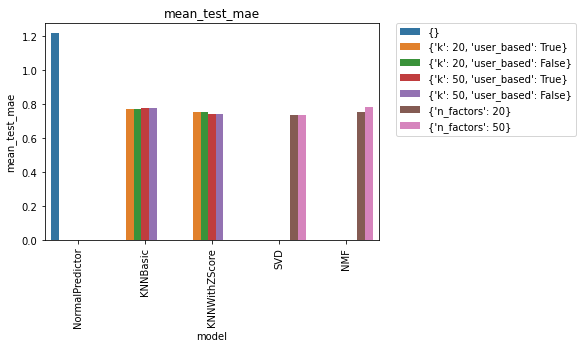

,model,params,mean_fit_time
0,NormalPredictor,{},0.161963
3,KNNBasic,"{'k': 50, 'user_based': False}",0.535496
2,KNNBasic,"{'k': 50, 'user_based': True}",0.539585
0,KNNBasic,"{'k': 20, 'user_based': True}",0.551211
1,KNNBasic,"{'k': 20, 'user_based': False}",0.639599
3,KNNWithZScore,"{'k': 50, 'user_based': False}",0.715415
0,KNNWithZScore,"{'k': 20, 'user_based': True}",0.754664
2,KNNWithZScore,"{'k': 50, 'user_based': True}",0.787494
1,KNNWithZScore,"{'k': 20, 'user_based': False}",0.805600
0,SVD,{'n_factors': 20},4.049326


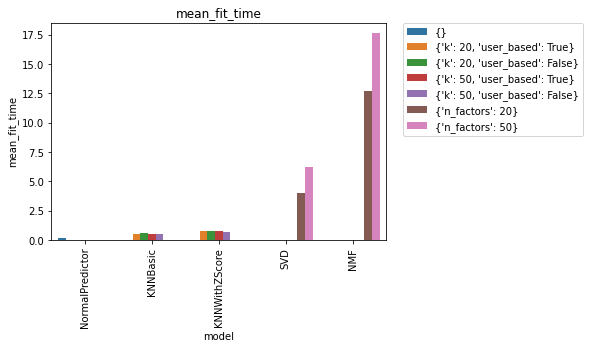

,model,params,mean_test_time
1,NMF,{'n_factors': 50},0.248996
0,NormalPredictor,{},0.278729
0,NMF,{'n_factors': 20},0.299803
1,SVD,{'n_factors': 50},0.447793
0,SVD,{'n_factors': 20},0.467120
1,KNNBasic,"{'k': 20, 'user_based': False}",6.935478
0,KNNBasic,"{'k': 20, 'user_based': True}",6.986600
0,KNNWithZScore,"{'k': 20, 'user_based': True}",7.832572
1,KNNWithZScore,"{'k': 20, 'user_based': False}",7.915780
3,KNNBasic,"{'k': 50, 'user_based': False}",7.918975


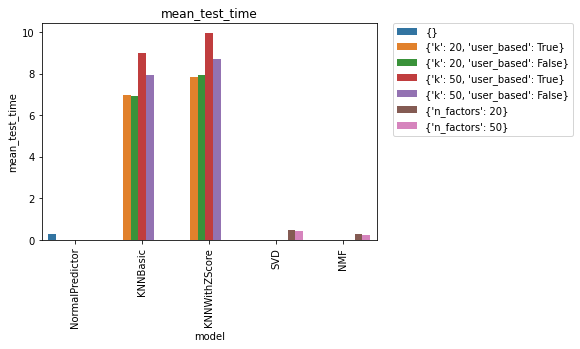

In [55]:
plot_metrics = ['mean_test_mae', 'mean_fit_time', 'mean_test_time']

for metric in plot_metrics:
    display(cv_results.sort_values(metric)[["model", "params", metric]])
    fig = sns.barplot(data=cv_results, hue='params', y=metric, x='model')
    fig.set_title(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    plt.show()